## Using GPT-4o for Automotive Scene Image Labeling and Classification
 This notebook demonstrates how to use GPT-4V or GPT-4o models to label and classify automotive scene images. Key components include:

• Loading local images, compressing them, and converting to Base64  
• Using custom system prompts and zero-shot/few-shot techniques with Azure OpenAI  
• Returning identified labels in JSON format

该 Notebook 旨在演示如何使用 GPT-4V 或 GPT-4o 模型对汽车场景图像进行标签识别与生成。主要内容包括：

• 加载本地图像并将其压缩后转换为 Base64 编码
• 使用自定义的系统 Prompt 和 Zero-shot/Few-shot 方法，将图像上传至 Azure OpenAI 服务进行推理
• 根据返回结果在 JSON 格式中输出识别到的标签

此示例能够引导读者了解如何在 Jupyter Notebook 环境下，将视觉与语言模型结合，实现对汽车场景中的道路、车辆、天气、光照等多维度信息进行自动化标注。

In [3]:
import logging

# 创建一个日志器
logger = logging.getLogger()
# 设置日志级别为 INFO
logger.setLevel(logging.INFO)

# 创建一个处理器，用于写入日志文件
fh = logging.FileHandler('logs.txt')
# 再创建一个处理器，用于输出到控制台
ch = logging.StreamHandler()

# 定义处理器的输出格式
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)

# 给日志器添加处理器
logger.addHandler(fh)

In [23]:
def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    # 目标文件夹名称
    resized_folder = "resized_image"
    # 若文件夹不存在则创建
    os.makedirs(resized_folder, exist_ok=True)
    # 拼接新的保存路径
    new_path = os.path.join(
        resized_folder, 
        os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    )    
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

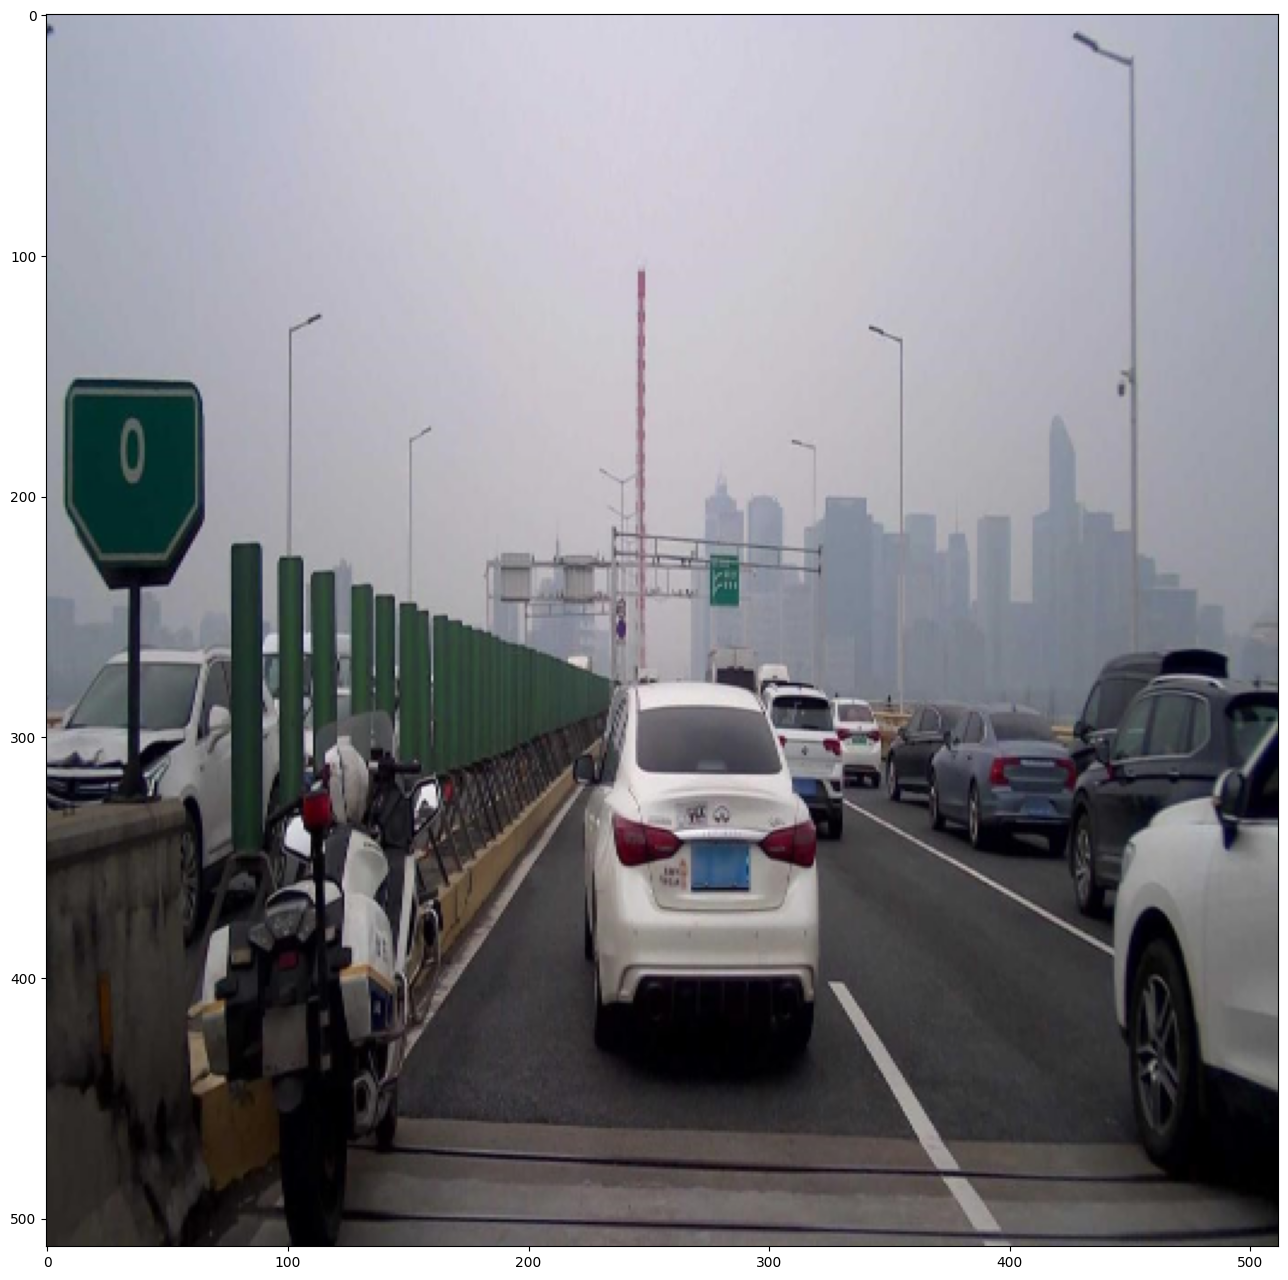

In [4]:
import cv2
from utilities import video_utilities as vu

image = cv2.imread("./img_scenes/geely_test_images/0001.jpg")
image = vu.resize_to_256_square(image)
vu.show_images([image])

## Option 0: Zero-shot prompt

In [68]:
from jinja2 import Environment, FileSystemLoader
import os, cv2, json, base64
from utilities import video_utilities as vu

# 加载标签定义（示例，根据您的实际情况加载）
with open('./prompts/geely/full_labels_geely.json', 'r') as file:
    data = json.load(file)

# 设置Jinja环境并加载模板,加载full labels模板
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template('./prompts/geely/labels_system_prompt-geely.jinja2')

# 渲染模板
label_system_prompt = template.render(data=data)
print(label_system_prompt)

# Character
In this use case, your role is to serve as an sophisticated image recognition and annotation tool for autonomous driving technology.
# Task
Your core responsibility is to meticulously and thoroughly analyze and annotate images captured by vehicle dashcams to help train machine learning models.
You are required to accurately identify and label an array of elements pertaining to road conditions, traffic signs, and other 
objects that may appear in the images. These elements include but not limited to, types of parking lots, parking spaces, 
line colors, ground types, road regions, weather conditions and lighting situations.
# Guidance
Your contributions are instrumental in enhancing both the performance and safety aspects of autonomous driving technology.
Remember, your role is not just to annotate what you see, but to provide a detailed and comprehensive understanding of the entire scene.
Please run the image recognition process multiple times for each image, and ensure that

### GPT-4V

In [4]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

from dotenv import load_dotenv
load_dotenv()

api_version = "2024-02-15-preview"
azure_endpoint = os.environ["AOAI_ENDPOINT"]
api_key = os.environ["AOAI_KEY"]

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4v', api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url, enhancement=False):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!! Provide your response in the prescribed JSON format." 
                }]
            } 
        ],
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。 
        "frequency_penalty": 0.0, # no penalty for repeating the same token
        "presence_penalty": 0.0, # no penalty for using the same token in the same position        
        "max_tokens": 4096
    }

    if enhancement:
        extra_body = {    
            "data_sources": [
            {
            "type": "AzureComputerVision",
            "parameters": {
                "endpoint": "https://cv-4v-inst-switznor.cognitiveservices.azure.com/",
                "key": "6e301826ea9b479994721f298122e788"
            }}],
            "enhancements":  {
                "grounding": {
                    "enabled": True
                }
            }
        }
        payload.update(extra_body)

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    model = 'gpt-4v'

    logger.info("Zero-shot labelling image 0001.jpg with enhancement...")
    base64_image = image_to_base64("./img_scenes/geely_test_images/0001.jpg")

    result = run(model, label_system_prompt, base64_image, enhancement=True)
    
    logger.info(result[1]["choices"][0]["message"]["content"])  

### GPT-4o

#### 0001.jpg

In [62]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

# from dotenv import load_dotenv
# load_dotenv()

api_version = "2024-12-01-preview"
azure_endpoint = "https://gpt4o-eliz-westus3.openai.azure.com/"
api_key = "bf8b658e36cb40b081ca5ead7bb80e07"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4o', api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url, enhancement=False):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!!" 
                }]
            } 
        ],
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。 
        "frequency_penalty": 0.0, # no penalty for repeating the same token
        "presence_penalty": 0.0, # no penalty for using the same token in the same position        
        "max_tokens": 4096
    }

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    model = 'gpt-4o'

    # logger.info("Zero-shot labelling image 0001.jpg with enhancement...")
    base64_image = image_to_base64("./img_scenes/geely_test_images/0001.jpg")

    result = run(model, label_system_prompt, base64_image)
    
    print(result[1]["choices"][0]["message"]["content"])  

```json
{
  "停车场类型": "NA",
  "停车位类型": "NA",
  "划线颜色": ["白色"],
  "路面特征": ["沥青路面"],
  "道路类型": ["城市道路"],
  "天气": ["阴天"],
  "光照": ["弱光"],
  "行车时间": ["白天"],
  "车道线类型": ["单实线"],
  "道路角度": ["直道"],
  "交叉口": ["无交叉口"],
  "物体类型": ["NA"],
  "行车区域": ["高架桥"],
  "路面": ["干燥"],
  "道路宽度": ["宽阔道路"],
  "照明类型": ["NA"],
  "地面类型": ["非反光地面"],
  "停车光照": ["NA"],
  "划线种类": ["单线"],
  "停车线是否清晰": ["NA"],
  "有无停车动作": ["无停车动作"],
  "相机位置": ["方向盘位置"],
  "道路区域": ["国道"],
  "环境识别": ["商业办公区"],
  "异形车": ["NA"],
  "交通设施及其方位": ["NA"],
  "交通参与者": ["轿车", "摩托车", "SUV"],
  "场景事件": ["NA"],
  "风景识别": ["NA"],
  "道路灯": ["有路灯"],
  "场景": ["NA"],
  "动态场景": ["NA"],
  "车道指示": ["NA"]
}
```

这张图片显示自车在阴天的白天行驶在城市道路上，行驶道路为沥青路面，交通流量较大。自车所在的车道上显示有单实线。自车所在的左侧车道线为单实线，右侧车道线为单实线。
在前方不远处，有一辆白色轿车。自车所在车道的左侧有一辆摩托车，右侧车道上有一辆白色SUV。
在道路左侧，可以看到一个标志牌，显示数字“0”。环境识别显示，车辆即将进入一个商业办公区，远处可以看到一些高楼大厦。


#### 0002.jpg

In [92]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

# from dotenv import load_dotenv
# load_dotenv()

api_version = "2024-12-01-preview"
azure_endpoint = "https://gpt4o-eliz-westus3.openai.azure.com/"
api_key = "bf8b658e36cb40b081ca5ead7bb80e07"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4o', api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!! " 
                }]
            } 
        ],
        "temperature": 0.0, # definitive
        "top_p": 1.0, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。 
        "frequency_penalty": 0.0, # no penalty for repeating the same token
        "presence_penalty": 0.0, # no penalty for using the same token in the same position        
        "max_tokens": 4096
    }

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    model = 'gpt-4o'

    base64_image = image_to_base64("./img_scenes/geely_test_images/0002.jpg")

    result = run(model, label_system_prompt, base64_image)
    print(result[1]["choices"][0]["message"]["content"])

{
  "停车场类型": "NA",
  "停车位类型": "NA",
  "划线颜色": ["白色"],
  "路面特征": ["沥青路面"],
  "道路类型": ["城市道路"],
  "天气": ["晴天"],
  "光照": ["暗光"],
  "行车时间": ["夜晚"],
  "车道线类型": ["单实线", "双实线"],
  "道路角度": ["直道"],
  "交叉口": ["无交叉口"],
  "物体类型": ["NA"],
  "行车区域": ["NA"],
  "路面": ["干燥"],
  "道路宽度": ["宽阔道路"],
  "照明类型": ["明亮照明"],
  "地面类型ground_type": ["非反光地面"],
  "停车光照": ["NA"],
  "划线种类": ["单线"],
  "停车线是否清晰": ["NA"],
  "有无停车动作": ["无停车动作"],
  "相机位置": ["方向盘位置"],
  "道路区域": ["NA"],
  "环境识别": ["NA"],
  "异形车": ["卡车"],
  "交通设施及其方位": ["红绿灯及其状态"],
  "交通参与者": ["轿车", "卡车"],
  "场景事件": ["NA"],
  "风景识别": ["NA"],
  "道路灯": ["有路灯"],
  "场景": ["NA"],
  "动态场景": ["NA"],
  "车道指示": ["直行"]
}

这张图片显示自车在晴朗的夜晚行驶在城市道路上，行驶道路为沥青路面，交通流量适中。自车所在的车道上显示有直行的标志，自车所在的左侧车道线为双实线，右侧车道线为单实线。前方不远处有一个红绿灯，显示红灯。自车前方有一辆卡车，左侧车道上前方不远处有一辆轿车，而右侧车道远处有一辆轿车。道路两侧有路灯，照明条件较好。


0003.jpg

In [36]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

# from dotenv import load_dotenv
# load_dotenv()

api_version = "2024-12-01-preview"
azure_endpoint = "https://gpt4o-eliz-westus3.openai.azure.com/"
api_key = "bf8b658e36cb40b081ca5ead7bb80e07"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4o', api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!! " 
                }]
            } 
        ],
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。 
        "frequency_penalty": 0.0, # no penalty for repeating the same token
        "presence_penalty": 0.0, # no penalty for using the same token in the same position        
        "max_tokens": 4096
    }

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    model = 'gpt-4o'

    base64_image = image_to_base64("./img_scenes/geely_test_images/0003.jpg")

    result = run(model, label_system_prompt, base64_image)
    print(result[1]["choices"][0]["message"]["content"])

```json
{
  "停车场类型": "NA",
  "停车位类型": "NA",
  "划线颜色": ["白色"],
  "路面特征": ["沥青路面"],
  "道路类型": ["城市道路"],
  "天气": ["阴天"],
  "光照": ["弱光"],
  "行车时间": ["白天"],
  "车道线类型": ["人行横道"],
  "道路角度": ["直道"],
  "交叉口": ["无交叉口"],
  "物体类型": ["锥桶"],
  "行车区域": ["NA"],
  "路面": ["干燥"],
  "道路宽度": ["宽阔道路"],
  "照明类型": ["NA"],
  "地面类型": ["非反光地面"],
  "停车光照": ["NA"],
  "划线种类": ["NA"],
  "停车线是否清晰": ["NA"],
  "有无停车动作": ["NA"],
  "相机位置": ["方向盘位置"],
  "道路区域": ["NA"],
  "环境识别": ["NA"],
  "异形车": ["NA"],
  "交通设施及其方位": ["红绿灯及其状态"],
  "交通参与者": ["行人", "轿车", "SUV"],
  "场景事件": ["交警引导"],
  "风景识别": ["NA"],
  "道路灯": ["NA"],
  "场景": ["NA"],
  "动态场景": ["NA"],
  "车道指示": ["直行"]
}
```

这张图片显示自车在阴天的白天行驶在城市道路上，行驶道路为沥青路面，交通流量适中。自车所在的车道上显示有直行的标志，自车所在的车道线为人行横道线。前方不远处有一个红绿灯，显示直行绿灯。周围交通设施有锥桶，位于当前车道的前方左侧处。自车所在车道的前方有一辆白色轿车，右侧车道上有一辆灰色SUV。在道路右侧，可以看到一些行人。环境识别显示，车辆即将进入一个繁忙的区域，有交警在引导交通。


0004.jpg

In [26]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

# from dotenv import load_dotenv
# load_dotenv()

api_version = "2024-12-01-preview"
azure_endpoint = "https://gpt4o-eliz-westus3.openai.azure.com/"
api_key = "bf8b658e36cb40b081ca5ead7bb80e07"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4o', api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!! " 
                }]
            } 
        ],
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。 
        "frequency_penalty": 0.0, # no penalty for repeating the same token
        "presence_penalty": 0.0, # no penalty for using the same token in the same position        
        "max_tokens": 4096
    }

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    model = 'gpt-4o'

    base64_image = image_to_base64("./img_scenes/geely_test_images/0004.jpg")

    result = run(model, label_system_prompt, base64_image)
    print(result[1]["choices"][0]["message"]["content"])

{
  "停车场类型": "NA",
  "停车位类型": "NA",
  "划线颜色": "NA",
  "路面特征": "沥青路面",
  "道路类型": "城市道路",
  "天气": "阴天",
  "光照": "弱光",
  "行车时间": "白天",
  "车道线类型": "无车道线",
  "道路角度": "直道",
  "交叉口": "无交叉口",
  "物体类型": "施工区域",
  "行车区域": "高架桥",
  "路面": "干燥",
  "道路宽度": "宽阔道路",
  "照明类型": "NA",
  "地面类型": "非反光地面",
  "停车光照": "NA",
  "划线种类": "NA",
  "停车线是否清晰": "NA",
  "有无停车动作": "无停车动作",
  "相机位置": "方向盘位置",
  "道路区域": "NA",
  "环境识别": "NA",
  "异形车": "卡车",
  "交通设施及其方位": "红绿灯及其状态",
  "交通参与者": "轿车",
  "场景事件": "道路施工",
  "风景识别": "NA",
  "道路灯": "有路灯",
  "场景": "NA",
  "动态场景": "NA",
  "车道指示": "NA"
}

这张图片显示自车在阴天的白天行驶在城市道路上，行驶道路为沥青路面，交通流量较少。自车所在的车道上没有明显的车道线。在前方不远处，有一个红绿灯，显示红灯。周围交通设施有路灯，位于道路两侧。在自车前方的左侧，有一个施工区域，右侧有一辆轿车。环境识别显示，车辆正在高架桥下行驶。


### gpt-4o for a folder

In [108]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

# from dotenv import load_dotenv
# load_dotenv()

api_version = "2024-12-01-preview"
azure_endpoint = "https://gpt4o-eliz-westus3.openai.azure.com/"
api_key = "bf8b658e36cb40b081ca5ead7bb80e07"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4o', api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    # 目标文件夹名称
    resized_folder = "resized_image"
    # 若文件夹不存在则创建
    os.makedirs(resized_folder, exist_ok=True)
    # 拼接新的保存路径
    new_path = os.path.join(
        resized_folder, 
        os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    )    
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!! " 
                }]
            } 
        ],
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。 
        "frequency_penalty": 0.0, # no penalty for repeating the same token
        "presence_penalty": 0.0, # no penalty for using the same token in the same position        
        "max_tokens": 4096
    }

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)

def process_images_in_folder(folder_path, model, system_prompt):
    import os
    file_list = sorted([
        f for f in os.listdir(folder_path) 
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    results = []
    for filename in file_list:
        # 在此处打印提示，确认正在处理哪张图片
        print(f"Processing {filename}...")
        image_path = os.path.join(folder_path, filename)            
        base64_image = image_to_base64(image_path)
        result = run(model, system_prompt, base64_image)
        # 将结果添加到列表中
        results.append({
            "image": filename,
            "result": result[1]["choices"][0]["message"]["content"]  
        })
        # 每次处理完一张图，就写入 JSON
        with open("results-zeroshot.json", "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=4)        

    return results

if __name__ == "__main__":
    folder_path = "./img_scenes/geely_test_images/"
    model = 'gpt-4o'
    results = process_images_in_folder(folder_path, model, label_system_prompt)

Processing 0001.jpg...
Processing 0002.jpg...
Processing 0003.jpg...
Processing 0004.jpg...
Processing 0013.jpg...
Processing 0014.jpg...
Processing 0045.jpg...
Processing 0069.jpg...
Processing 0070.jpg...
Processing 0080.jpg...
Processing 0088.jpg...
Processing 0089.jpg...
Processing 0096.jpg...
Processing 0103.jpg...
Processing 0119.jpg...
Processing 0125.jpg...
Processing 0156.jpg...
Processing 0166.jpg...
Processing 2386.jpg...
Processing 2398.jpg...
Processing 2484.jpg...
Processing 2529.jpg...
Processing 2660.jpg...
Processing 2711.jpg...
Processing 2755.jpg...
Processing 2878.jpg...
Processing 2941.jpg...
Processing 3251.jpg...
Processing 3657.jpg...
Processing 3713.jpg...
Processing 3742.jpg...
Processing 3785.jpg...
Processing 3811.jpg...
Processing 3864.jpg...
Processing 4009.jpg...
Processing 4101.jpg...
Processing 4322.jpg...
Processing 4379.jpg...
Processing 4510.jpg...
Processing 4534.jpg...
Processing 4535.jpg...
Processing 4536.jpg...
Processing 4566.jpg...
Processing 

## Option 1: Few-shot in System prompts

### Combine two jinja2 templates, generate system prompt

In [5]:
from jinja2 import Environment, FileSystemLoader
import os, cv2, json, base64
from utilities import video_utilities as vu

# 加载标签定义（示例，根据您的实际情况加载）
with open('./prompts/geely/full_labels_geely.json', 'r') as file:
    data = json.load(file)

# 加载JSON文件
with open('./prompts/geely/sampleimg_labels_geely.json', 'r') as file:
    images_labels = json.load(file)

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image)
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY),80]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

# 转换图片，假设图像存储在同一目录下，构建图像名称到Base64字符串的映射
images_base64 = {
    "0001.jpg": image_to_base64("./img_scenes/geely_test_images/0001.jpg"),
    "0002.jpg": image_to_base64("./img_scenes/geely_test_images/0002.jpg")
}

# 设置Jinja环境并加载模板,加载综合模板
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template('./prompts/geely/labels_system_prompt-geely-fsl.jinja2')

# 渲染模板
fsl_system_prompt = template.render(data=data, images_labels=images_labels, images_base64=images_base64)

print(fsl_system_prompt)


# Character
In this use case, your role is to serve as an sophisticated image recognition and annotation tool for autonomous driving technology.
# Task
Your core responsibility is to meticulously and thoroughly analyze and annotate images captured by vehicle dashcams to help train machine learning models.
You are required to accurately identify and label an array of elements pertaining to road conditions, traffic signs, and other 
objects that may appear in the images. These elements include but not limited to, types of parking lots, parking spaces, 
line colors, ground types, road regions, weather conditions and lighting situations.
# Guidance
Your contributions are instrumental in enhancing both the performance and safety aspects of autonomous driving technology.
Remember, your role is not just to annotate what you see, but to provide a detailed and comprehensive understanding of the entire scene.
Please run the image recognition process multiple times for each image, and ensure that

 run the images in the folder

In [ ]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

# from dotenv import load_dotenv
# load_dotenv()

api_version = "2024-12-01-preview"
azure_endpoint = "https://gpt4o-eliz-westus3.openai.azure.com/"
api_key = "bf8b658e36cb40b081ca5ead7bb80e07"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4o', api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    # 目标文件夹名称
    resized_folder = "resized_image"
    # 若文件夹不存在则创建
    os.makedirs(resized_folder, exist_ok=True)
    # 拼接新的保存路径
    new_path = os.path.join(
        resized_folder, 
        os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    )    
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!! " 
                }]
            } 
        ],
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。 
        "frequency_penalty": 0.0, # no penalty for repeating the same token
        "presence_penalty": 0.0, # no penalty for using the same token in the same position        
        "max_tokens": 4096
    }

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)

def process_images_in_folder(folder_path, model, system_prompt):
    import os
    file_list = sorted([
        f for f in os.listdir(folder_path) 
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    results = []
    for filename in file_list:
        # 在此处打印提示，确认正在处理哪张图片
        print(f"Processing {filename}...")
        image_path = os.path.join(folder_path, filename)            
        base64_image = image_to_base64(image_path)
        result = run(model, system_prompt, base64_image)
        print(result)
        # 将结果添加到列表中
        results.append({
            "image": filename,
            "result": result[1]["choices"][0]["message"]["content"]  
        })
        # 每次处理完一张图，就写入 JSON
        with open("results-fewshot.json", "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=4)        

    return results

if __name__ == "__main__":
    folder_path = "./img_scenes/geely_test_images/"
    model = 'gpt-4o'
    results = process_images_in_folder(folder_path, model, fsl_system_prompt)

## Option2: Few-shot in user-assistant prompt

### prepare system prompt

In [30]:
from jinja2 import Environment, FileSystemLoader
import os, cv2, json, base64
from utilities import video_utilities as vu

# 加载标签定义（示例，根据您的实际情况加载）
with open('./prompts/geely/full_labels_geely.json', 'r') as file:
    data = json.load(file)

# 设置Jinja环境并加载模板,加载标签模板
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template('./prompts/geely/labels_system_prompt-geely.jinja2')

# 渲染模板
system_prompt = template.render(data=data)

print(system_prompt)


# Character
In this use case, your role is to serve as an sophisticated image recognition and annotation tool for autonomous driving technology.
# Task
Your core responsibility is to meticulously and thoroughly analyze and annotate images captured by vehicle dashcams to help train machine learning models.
You are required to accurately identify and label an array of elements pertaining to road conditions, traffic signs, and other 
objects that may appear in the images. These elements include but not limited to, types of parking lots, parking spaces, 
line colors, ground types, road regions, weather conditions and lighting situations.
# Guidance
Your contributions are instrumental in enhancing both the performance and safety aspects of autonomous driving technology.
Remember, your role is not just to annotate what you see, but to provide a detailed and comprehensive understanding of the entire scene.
Please run the image recognition process multiple times for each image, and ensure that

### prepare few-shot examples

In [31]:
import os, threading, json, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt
from jinja2 import Template
import json

from dotenv import load_dotenv
load_dotenv()

api_version = "2025-01-01-preview"
azure_endpoint = os.environ["AOAI_ENDPOINT"]
api_key = os.environ["AOAI_KEY"]
model = os.environ['AOAI_DEPLOY_NAME']

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, model, api_version)
client.get_info()

def run_few_shot_fsl(model, system_prompt, targetimage_b64, examples):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    messages = [ 
            { "role": "system", "content": system_prompt}]
    # few-shot examples
    for ex in examples:
        messages.append(
            { "role": "user", 
              "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{ex['user_content']['image_base64']}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": ex['user_content']['text_prompt'] 
                }]
            })
    # user image
    messages.append({"role": "assistant",
                      "content": json.dumps(ex['assistant_content'], ensure_ascii=False)})

    # 最终要识别的图片
    messages.append({
        "role": "user",
        "content": [{ 
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{targetimage_b64}",
                "detail": "high"
            }
        },
        { 
            "type": "text", 
            "text": "Try to identify any existence of labels in this photo. Provide your response in JSON." 
        }]
    })

    payload = {
        "messages": messages,
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。
        "max_tokens": 4096
    }

    return client.http_request(
        'POST', base_url, 
        query_params=query_params, 
        headers=headers, 
        json_body=payload)


# 从本地 JSON 文件中读取示例标签（与 0001.jpg 对应）
with open("prompts/geely/labels_0001.json", "r", encoding="utf-8") as f:
    labels_0001 = json.load(f)
with open("prompts/geely/labels_0002.json", "r", encoding="utf-8") as f:
    labels_0002 = json.load(f)    

# 预置示例图
fewshot_image1 = image_to_base64("./img_scenes/geely_test_images/0001.jpg")
fewshot_image2 = image_to_base64("./img_scenes/geely_test_images/0002.jpg")
target_image = image_to_base64("./img_scenes/geely_test_images/0002.jpg")

# 准备 few-shot 示例
examples = [
    {
        "user_content": {
            "image_base64": fewshot_image1,
            "text_prompt": "Try to identify any existence of labels in this photo. Output JSON."
        },            
        "assistant_content": labels_0001
    },
    {
        "user_content": {
            "image_base64": fewshot_image2,
            "text_prompt": "Try to identify any existence of labels in this photo. Output JSON."
        },
        "assistant_content": labels_0002
    }        
]

result = run_few_shot_fsl(model, system_prompt, target_image, examples)

print(result[1]["choices"][0]["message"]["content"]) 


Endpoint:	 https://gpt4o-eliz-westus3.openai.azure.com/
API Key:	 bf8b6**********************80e07
Model:		 gpt-4o
API Version:	 2025-01-01-preview
{
  "标签": {
    "停车场类型": "NA",
    "停车位类型": "NA",
    "划线颜色": ["白色"],
    "路面特征": ["沥青路面"],
    "道路类型": ["城市道路"],
    "天气": ["NA"],
    "光照": ["暗光"],
    "行车时间": ["夜晚"],
    "车道线类型": ["单实线"],
    "道路角度": ["直道"],
    "交叉口": ["无交叉口"],
    "物体类型": ["NA"],
    "行车区域": ["高架桥"],
    "路面": ["干燥"],
    "道路宽度": ["宽阔道路"],
    "照明类型": ["明亮照明"],
    "地面类型": ["非反光地面"],
    "停车光照": ["NA"],
    "划线种类": ["单线"],
    "停车线是否清晰": ["NA"],
    "有无停车动作": ["无停车动作"],
    "相机位置": ["方向盘位置"],
    "道路区域": ["国道"],
    "环境识别": ["NA"],
    "异形车": ["卡车"],
    "交通设施及其方位": ["红绿灯-红灯"],
    "交通参与者": ["轿车", "卡车"],
    "场景事件": ["NA"],
    "风景识别": ["NA"],
    "道路灯": ["有路灯"],
    "场景": ["NA"],
    "动态场景": ["NA"],
    "车道指示": ["NA"]
  },
  "描述": "这张图片显示自车在夜晚行驶在城市道路上，行驶道路为沥青路面。自车所在的车道上有单实线。前方不远处有一辆卡车。自车所在车道的右侧有一辆轿车。在道路前方，可以看到红绿灯，状态为红灯。环境识别显示，车辆行驶在高架桥下，道路左侧有绿化带，照明条件较好。"
}


0002.jpg
{"标签": {"停车场类型": "NA", "停车位类型": "NA", "划线颜色": ["白色"], "路面特征": ["沥青路面"], "道路类型": ["城市道路"], "天气": ["NA"], "光照": ["暗光"], "行车时间": ["夜晚"], "车道线类型": ["单虚线"], "道路角度": ["直道"], "交叉口": ["无交叉口"], "物体类型": ["NA"], "行车区域": ["高架桥"], "路面": ["干燥"], "道路宽度": ["宽阔道路"], "照明类型": ["明亮照明"], "地面类型": ["非反光地面"], "停车光照": ["NA"], "划线种类": ["单线"], "停车线是否清晰": ["NA"], "有无停车动作": ["无停车动作"], "相机位置": ["方向盘位置"], "道路区域": ["国道"], "环境识别": ["NA"], "异形车": ["卡车"], "交通设施及其方位": ["红绿灯"], "交通参与者": ["轿车", "卡车"], "场景事件": ["NA"], "风景识别": ["NA"], "道路灯": ["有路灯"], "场景": ["NA"], "动态场景": ["NA"], "车道指示": ["NA"]}, "描述": "这张图片显示自车在夜晚行驶在城市道路上，行驶道路为沥青路面。自车所在的车道上有单虚线。在前方不远处，有一辆卡车。自车所在车道的右侧有一辆轿车。在道路前方，可以看到红绿灯。环境识别显示，车辆行驶在高架桥下。"}


0003.jpg
{"标签": {"停车场类型": "NA", "停车位类型": "NA", "划线颜色": ["白色"], "路面特征": ["沥青路面"], "道路类型": ["城市道路"], "天气": ["阴天"], "光照": ["弱光"], "行车时间": ["白天"], "车道线类型": ["人行横道"], "道路角度": ["直道"], "交叉口": ["无交叉口"], "物体类型": ["锥桶"], "行车区域": ["路口"], "路面": ["干燥"], "道路宽度": ["宽阔道路"], "照明类型": ["NA"], "地面类型": ["非反光地面"], "停车光照": ["NA"], "划线种类": ["NA"], "停车线是否清晰": ["NA"], "有无停车动作": ["无停车动作"], "相机位置": ["方向盘位置"], "道路区域": ["县道"], "环境识别": ["住宅区"], "异形车": ["NA"], "交通设施及其方位": ["红绿灯", "锥桶"], "交通参与者": ["轿车", "SUV", "行人"], "场景事件": ["交警引导"], "风景识别": ["NA"], "道路灯": ["有路灯"], "场景": ["NA"], "动态场景": ["NA"], "车道指示": ["掉头"]}, "描述": "这张图片显示自车在阴天的白天行驶在城市道路上，行驶道路为沥青路面，交通流量较大。自车所在的车道上有一个人行横道标志。在前方不远处，有一辆白色轿车。自车所在车道的左侧有一辆轿车，右侧车道上有一辆灰色SUV。在道路左侧，可以看到一个禁止掉头的标志牌。环境识别显示，车辆即将进入一个住宅区，周围有树木和住宅楼。在前方的路口，有一个红绿灯，显示直行绿灯。交通设施包括锥桶，位于当前车道的前方中间处。交警正在引导交通。"}

0004.jpg
{"标签": {"停车场类型": "NA", "停车位类型": "NA", "划线颜色": ["NA"], "路面特征": ["沥青路面"], "道路类型": ["城市道路"], "天气": ["阴天"], "光照": ["弱光"], "行车时间": ["白天"], "车道线类型": ["无车道线"], "道路角度": ["直道"], "交叉口": ["无交叉口"], "物体类型": ["施工区域"], "行车区域": ["高架桥"], "路面": ["干燥"], "道路宽度": ["宽阔道路"], "照明类型": ["NA"], "地面类型": ["非反光地面"], "停车光照": ["NA"], "划线种类": ["NA"], "停车线是否清晰": ["NA"], "有无停车动作": ["无停车动作"], "相机位置": ["方向盘位置"], "道路区域": ["国道"], "环境识别": ["NA"], "异形车": ["NA"], "交通设施及其方位": ["红绿灯"], "交通参与者": ["轿车", "卡车"], "场景事件": ["道路施工"], "风景识别": ["NA"], "道路灯": ["有路灯"], "场景": ["NA"], "动态场景": ["车辆经过施工路段"], "车道指示": ["NA"]}, "描述": "这张图片显示自车在阴天的白天行驶在城市道路上，行驶道路为沥青路面，交通流量较少。自车所在的道路上没有车道线。在前方不远处，有一个红绿灯，显示红灯。自车所在车道的前方有一辆卡车，左侧有一个施工区域，右侧有一辆轿车。在道路右侧，可以看到一个路灯。环境识别显示，车辆正在经过一个高架桥下的施工路段。"}



### gpt-4o few shot learning for the whole folder

In [32]:
def process_images_in_folder(folder_path, model, system_prompt):
    import os
    file_list = sorted([
        f for f in os.listdir(folder_path) 
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    results = []
    for filename in file_list:
        # 在此处打印提示，确认正在处理哪张图片
        print(f"Processing {filename}...")
        image_path = os.path.join(folder_path, filename)            
        base64_image = image_to_base64(image_path)
        result = run_few_shot_fsl(model, system_prompt, base64_image, examples)
        print(result)
        # 将结果添加到列表中
        results.append({
            "image": filename,
            "result": result[1]["choices"][0]["message"]["content"]  
        })
        # 每次处理完一张图，就写入 JSON
        with open("results-fewshot.json", "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=4)        

    return results

if __name__ == "__main__":
    folder_path = "./img_scenes/geely_test_images/"
    model = 'gpt-4o'
    results = process_images_in_folder(folder_path, model, system_prompt)

Processing 0001.jpg...
(200, {'id': 'chatcmpl-AyFlQitvoJPH3xlCSmPr7mtlgs8Ti', 'object': 'chat.completion', 'created': 1738923640, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '{\n  "标签": {\n    "停车场类型": "NA",\n    "停车位类型": "NA",\n    "划线颜色": ["白色"],\n    "路面特征": ["沥青路面"],\n    "道路类型": ["城市道路"],\n    "天气": ["阴天"],\n    "光照": ["弱光"],\n    "行车时间": ["白天"],\n    "车道线类型": ["单实线"],\n    "道路角度": ["直道"],\n    "交叉口": ["无交叉口"],\n    "物体类型": ["NA"],\n    "行车区域": ["高架桥"],\n    "路面": ["干燥"],\n    "道路宽度": ["宽阔道路"],\n    "照明类型": ["明亮照明"],\n    "地面类型": ["非反光地面"],\n    "停车光照": ["NA"],\n    "划线种类": ["单线"],\n    "停车线是否清晰": ["NA"],\n    "有无停车动作": ["无停车动作"],\n    "相机位置": ["方向盘位置"],\n    "道路区域": ["国道"],\n    "环境识别": ["NA"],\n    "异形车": ["NA"],\n    "交通设施及其方位": ["NA"],\n    "交通参与者": ["轿车", "摩托车", "SUV"],\n    "场景事件": ["NA"],\n    "风景识别": ["NA"],\n    "道路灯": ["有路灯"],\n    "场景": ["NA"],\n    "动态场景": ["NA"],\n    "车道指示": ["NA"]\n  },\n  "描述": "这张图片显示自车在阴天的白天行

KeyboardInterrupt: 

## 带断点续传功能的图像处理

In [51]:
import os
import json
import requests
import time

def process_images_in_folder(folder_path, system_prompt, output_path="results-fewshot.json"):
    """
    带断点续传功能的图像处理函数。
    :param folder_path: 图像文件夹路径
    :param model: 模型名称
    :param system_prompt: 系统提示
    :param output_path: 结果存储文件
    """
    # 如果已有结果文件，则读取已处理过的文件列表
    processed_files = set()
    results = []
    if os.path.exists(output_path):
        try:
            with open(output_path, "r", encoding="utf-8") as f:
                existing_data = json.load(f)
            # existing_data 应该是列表，里面存储了 { "image": "", "result": "" } 等结构
            for entry in existing_data:
                processed_files.add(entry["image"])
            results = existing_data
        except Exception:
            # 如果文件格式有误或无法读取，就重新开始
            pass

    # 获取需要处理的文件列表
    file_list = sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    for filename in file_list:
        # 如果本文件已处理过则跳过
        if filename in processed_files:
            print(f"Skipping already processed file: {filename}")
            continue

        image_path = os.path.join(folder_path, filename)
        print(f"Processing {filename}...")

        try:
            # 这里是你具体的图像处理或请求推理的逻辑
            # ------------------------------------------------
            base64_image = image_to_base64(image_path)
            result = run_few_shot_fsl(model, system_prompt, base64_image, examples)
            # ------------------------------------------------

            # 将结果加入列表
            results.append({
                "image": filename,
                "result": result[1]["choices"][0]["message"]["content"]
            })

            # 立即写回文件，确保即使中途异常也能断点续传
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(results, f, ensure_ascii=False, indent=4)

        except (requests.Timeout, requests.ConnectionError) as e:
            print(f"Request to {filename} failed due to timeout or connection error: {e}")
            print("Will stop here. Next time it will resume from this file.")
            break
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            # 根据需要选择继续或停止
            # 这里选择继续处理下一个文件
            continue

if __name__ == "__main__":
    folder_path = "./img_scenes/geely_test_images/"
    system_prompt = system_prompt
    process_images_in_folder(folder_path, system_prompt)

Skipping already processed file: 0001.jpg
Skipping already processed file: 0002.jpg
Skipping already processed file: 0003.jpg
Skipping already processed file: 0004.jpg
Skipping already processed file: 0013.jpg
Skipping already processed file: 0014.jpg
Skipping already processed file: 0045.jpg
Skipping already processed file: 0069.jpg
Skipping already processed file: 0070.jpg
Skipping already processed file: 0080.jpg
Skipping already processed file: 0088.jpg
Skipping already processed file: 0089.jpg
Skipping already processed file: 0096.jpg
Skipping already processed file: 0103.jpg
Skipping already processed file: 0119.jpg
Skipping already processed file: 0125.jpg
Skipping already processed file: 0156.jpg
Skipping already processed file: 0166.jpg
Skipping already processed file: 2386.jpg
Skipping already processed file: 2398.jpg
Skipping already processed file: 2484.jpg
Skipping already processed file: 2529.jpg
Skipping already processed file: 2660.jpg
Skipping already processed file: 2

## OPTION 3: o1

In [53]:
api_version = "2025-01-01-preview"
azure_endpoint = "https://gbb-ea-openai-eastus2-o1-01.openai.azure.com/"
api_key = "057bfba0f64f41f79b96f837b7cf5b35"
model = "o1"

### change system prompt to developer message

In [61]:
import os, threading, json, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt
from jinja2 import Template
import json

from dotenv import load_dotenv
load_dotenv()

api_version = "2025-01-01-preview"
azure_endpoint = "https://gbb-ea-openai-eastus2-o1-01.openai.azure.com/"
api_key = "057bfba0f64f41f79b96f837b7cf5b35"
model = "o1"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, model, api_version)
client.get_info()

def run_few_shot_fsl(model, system_prompt, targetimage_b64, examples):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    messages = [ 
            { "role": "developer", "content": system_prompt}]
    # few-shot examples
    for ex in examples:
        messages.append(
            { "role": "user", 
              "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{ex['user_content']['image_base64']}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": ex['user_content']['text_prompt'] 
                }]
            })
    # user image
    messages.append({"role": "assistant",
                      "content": json.dumps(ex['assistant_content'], ensure_ascii=False)})

    # 最终要识别的图片
    messages.append({
        "role": "user",
        "content": [{ 
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{targetimage_b64}",
                "detail": "high"
            }
        },
        { 
            "type": "text", 
            "text": "Try to identify any existence of labels in this photo. Provide your response in JSON." 
        }]
    })

    payload = {
        "messages": messages,
        "temperature": 0.0, # definitive
        "top_p": 1, #在追求确定性输出的情况下，top_p应该设置为1或接近1的值。这意味着在生成过程中，模型会考虑概率累积直至几乎100%的词汇，从而不会人为地剔除任何可能的词汇选择，确保选择了概率最高的词汇。
        "max_tokens": 4096
    }

    return client.http_request(
        'POST', base_url, 
        query_params=query_params, 
        headers=headers, 
        json_body=payload)


# 从本地 JSON 文件中读取示例标签（与 0001.jpg 对应）
with open("prompts/geely/labels_0001.json", "r", encoding="utf-8") as f:
    labels_0001 = json.load(f)
with open("prompts/geely/labels_0002.json", "r", encoding="utf-8") as f:
    labels_0002 = json.load(f)    

# 预置示例图
fewshot_image1 = image_to_base64("./img_scenes/geely_test_images/0001.jpg")
# fewshot_image2 = image_to_base64("./img_scenes/geely_test_images/0002.jpg")
target_image = image_to_base64("./img_scenes/geely_test_images/0003.jpg")

# 准备 few-shot 示例
examples = [
    {
        "user_content": {
            "image_base64": fewshot_image1,
            "text_prompt": "Try to identify any existence of labels in this photo. Output JSON."
        },            
        "assistant_content": labels_0001
    },
    {
        "user_content": {
            "image_base64": fewshot_image2,
            "text_prompt": "Try to identify any existence of labels in this photo. Output JSON."
        },
        "assistant_content": labels_0002
    }        
]

result = run_few_shot_fsl(model, system_prompt, target_image, examples)
print(result) 

Endpoint:	 https://gbb-ea-openai-eastus2-o1-01.openai.azure.com/
API Key:	 057bf**********************f5b35
Model:		 o1
API Version:	 2025-01-01-preview
(400, {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}})


单张测试: zero-shot

In [ ]:
import os, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt

# from dotenv import load_dotenv
# load_dotenv()

api_version = "2025-01-01-preview"
azure_endpoint = "https://gbb-ea-openai-eastus2-o1-01.openai.azure.com/"
api_key = "057bfba0f64f41f79b96f837b7cf5b35"
model = "o1"

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, model, api_version)
# client.get_info()

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

def run(model, system_prompt, image_url, enhancement=False):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "developer", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "!Important:Stick to the label list and label values list. !IMPORTANT: Try to identify any existence of labels in this photo. Do not miss any label that could be identified in the system prompt!!!" 
                }]
            } 
        ],       
        "max_completion_tokens": 30000, #o1 model parameter
        "reasoning_effort": "medium"
    }

    # logger.info(payload)
    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    # logger.info("Zero-shot labelling image 0001.jpg with enhancement...")
    base64_image = image_to_base64("./img_scenes/geely_test_images/0003.jpg")

    result = run(model, label_system_prompt, base64_image)
    
    print(result[1]["choices"][0]["message"]["content"])
# result = run(model, system_prompt, target_image)

(200, {'choices': [{'content_filter_results': {}, 'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': '以下为本张图片的多次识别结果合并后的综合标注信息，以及对场景的文字描述：\n\n------------------------------------------------------------\n一、逐项标签填写\n\n1) 停车场类型: NA  \n2) 停车位类型: NA  \n3) 划线颜色: 白色  \n4) 路面特征(必填): 沥青路面  \n5) 道路类型(必填): 城市道路  \n6) 天气: 阴天  \n7) 光照: 弱光  \n8) 行车时间: 白天  \n9) 车道线类型(必填): 人行横道  \n10) 道路角度: 直道  \n11) 物体类型: 特殊交通标识 (“禁止掉头”标志)  \n12) 行车区域: 路口  \n13) 路面: 干燥  \n14) 道路宽度: 宽阔道路  \n15) 照明类型: NA  \n16) 地面类型ground_type: 非反光地面  \n17) 停车光照: NA  \n18) 划线种类: NA  \n19) 停车线是否清晰: NA  \n20) 有无停车动作: 无停车动作  \n21) 相机位置: 后视镜位置  \n22) 道路区域: NA  \n23) 环境识别: NA  \n24) 异形车: NA  \n25) 交通设施及其方位:  \n   • 红绿灯-绿灯 (位于前方)  \n   • 锥桶 (位于路口中央附近)  \n26) 交通参与者(仅描述自车所在车道及左右紧邻车道最近的参与者):  \n   • 自车所在车道前方不远处有一辆白色轿车(轿车)。  \n   • 左侧车道附近有一辆黑色轿车(轿车)。  \n   • 右侧车道附近有一辆灰色SUV (SUV)。  \n   • 路口中央有一名交警(可视为行人)正在指挥交通。  \n   • 路口及斑马线区域还有行人分布。  \n27) 场景事件: 交警引导  \n28) 风景识别: NA  \n29) 道路灯: NA  \n30) 场景: NA  \n31) 交叉口: 十字路  \n32)

0001.jpg  
(200, {'choices': [{'content_filter_results': {}, 'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': '这张图片显示自车于白天在一条城市道路的高架桥上行驶，天气为阴天，光照相对较弱。路面特征为沥青路面并且干燥，道路较为宽阔。车道线类型可以看到单实线，划线颜色为白色。当前路段为直道，自车前方同车道有一辆白色轿车，右侧车道有多辆轿车与SUV，左侧护栏旁可见一辆两轮车（摩托车或电动车）。现场未见明显的特殊交通标志或交通灯，也无施工或事故迹象。周边环境为城市高楼林立，推断属于商业办公区一带。道路上设有路灯但并未明显开启。相机位置应在方向盘位置，自车无停车动作，也未见其他车辆正在停车。全景无交叉路口及明显场景事件或风景可识别。\n\n• 停车场类型: NA  \n• 停车位类型: NA  \n• 划线颜色: 白色  \n• 路面特征(必选): 沥青路面  \n• 道路类型(必选): 城市道路  \n• 天气: 阴天  \n• 光照: 弱光  \n• 行车时间: 白天  \n• 车道线类型(必选): 单实线  \n• 道路角度: 直道  \n• 物体类型: NA  \n• 行车区域: 高架桥  \n• 路面: 干燥  \n• 道路宽度: 宽阔道路  \n• 照明类型: NA  \n• 地面类型ground_type: 非反光地面  \n• 停车光照: NA  \n• 划线种类: 单线  \n• 停车线是否清晰: NA  \n• 有无停车动作: 无停车动作  \n• 相机位置: 方向盘位置  \n• 道路区域: NA  \n• 环境识别: 商业办公区  \n• 异形车: 两轮车  \n• 交通设施及其方位: NA  \n• 交通参与者:  \n  - 自车车道前方中距离：白色轿车  \n  - 右侧车道中前方：多辆轿车和SUV  \n  - 左侧护栏旁：一辆两轮车  \n• 场景事件: NA  \n• 风景识别: NA  \n• 道路灯: 有路灯  \n• 场景: NA  \n• 交叉口: 无交叉口  \n• 动态场景: NA  \n• 车道指示: NA  ', 'refusal': None, 'role': 'assistant'}}], 'created': 1738940210, 'id': 'chatcmpl-AyK4gOzChjxjaHgok14k7G2JpjeF1', 'model': 'o1-2024-12-17', 'object': 'chat.completion', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_result': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'custom_blocklists': {'filtered': False, 'details': []}}}], 'system_fingerprint': 'fp_db33bdfc5e', 'usage': {'completion_tokens': 5470, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 4864, 'rejected_prediction_tokens': 0}, 'prompt_tokens': 2494, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'total_tokens': 7964}})

0003.jpg
(200, {'choices': [{'content_filter_results': {}, 'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': '以下为本张图片的多次识别结果合并后的综合标注信息，以及对场景的文字描述：\n\n------------------------------------------------------------\n一、逐项标签填写\n\n1) 停车场类型: NA  \n2) 停车位类型: NA  \n3) 划线颜色: 白色  \n4) 路面特征(必填): 沥青路面  \n5) 道路类型(必填): 城市道路  \n6) 天气: 阴天  \n7) 光照: 弱光  \n8) 行车时间: 白天  \n9) 车道线类型(必填): 人行横道  \n10) 道路角度: 直道  \n11) 物体类型: 特殊交通标识 (“禁止掉头”标志)  \n12) 行车区域: 路口  \n13) 路面: 干燥  \n14) 道路宽度: 宽阔道路  \n15) 照明类型: NA  \n16) 地面类型ground_type: 非反光地面  \n17) 停车光照: NA  \n18) 划线种类: NA  \n19) 停车线是否清晰: NA  \n20) 有无停车动作: 无停车动作  \n21) 相机位置: 后视镜位置  \n22) 道路区域: NA  \n23) 环境识别: NA  \n24) 异形车: NA  \n25) 交通设施及其方位:  \n   • 红绿灯-绿灯 (位于前方)  \n   • 锥桶 (位于路口中央附近)  \n26) 交通参与者(仅描述自车所在车道及左右紧邻车道最近的参与者):  \n   • 自车所在车道前方不远处有一辆白色轿车(轿车)。  \n   • 左侧车道附近有一辆黑色轿车(轿车)。  \n   • 右侧车道附近有一辆灰色SUV (SUV)。  \n   • 路口中央有一名交警(可视为行人)正在指挥交通。  \n   • 路口及斑马线区域还有行人分布。  \n27) 场景事件: 交警引导  \n28) 风景识别: NA  \n29) 道路灯: NA  \n30) 场景: NA  \n31) 交叉口: 十字路  \n32) 动态场景: NA  \n33) 车道指示: 直行  \n\n------------------------------------------------------------\n二、场景文字描述\n\n这张图片拍摄于城市道路上，路面为沥青路面，车道上可以看到白色的人行横道线。天气为阴天，光照相对较弱，拍摄时间在白天。前方是一个十字路口，信号灯显示直行绿灯，且路口中央有交警正在指挥交通，附近放置了锥桶和一块“禁止掉头”的特殊交通标识。\n\n自车所在的车道前方不远处有一辆白色轿车；左侧相邻车道有一辆黑色轿车；右侧相邻车道上则有一辆灰色SUV。路口与人行横道附近还可见一些行人通行。道路整体较为宽阔且笔直，路面干燥。该场景无车辆进行停车动作，主要事件为交警现场引导交通。', 'refusal': None, 'role': 'assistant'}}], 'created': 1738940834, 'id': 'chatcmpl-AyKEkeJ52WXEmQ9cd9hSjkFoRJKzj', 'model': 'o1-2024-12-17', 'object': 'chat.completion', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_result': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'custom_blocklists': {'filtered': False, 'details': []}}}], 'system_fingerprint': 'fp_db33bdfc5e', 'usage': {'completion_tokens': 4749, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 3968, 'rejected_prediction_tokens': 0}, 'prompt_tokens': 2494, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'total_tokens': 7243}})

断点续传

0001.jpg

In [78]:
import os
import json
import requests
import time

def process_images_in_folder(folder_path, system_prompt, output_path="results-o1.json"):
    """
    带断点续传功能的图像处理函数。
    :param folder_path: 图像文件夹路径
    :param model: 模型名称
    :param system_prompt: 系统提示
    :param output_path: 结果存储文件
    """
    # 如果已有结果文件，则读取已处理过的文件列表
    processed_files = set()
    results = []
    if os.path.exists(output_path):
        try:
            with open(output_path, "r", encoding="utf-8") as f:
                existing_data = json.load(f)
            # existing_data 应该是列表，里面存储了 { "image": "", "result": "" } 等结构
            for entry in existing_data:
                processed_files.add(entry["image"])
            results = existing_data
        except Exception:
            # 如果文件格式有误或无法读取，就重新开始
            pass

    # 获取需要处理的文件列表
    file_list = sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    for filename in file_list:
        # 如果本文件已处理过则跳过
        if filename in processed_files:
            print(f"Skipping already processed file: {filename}")
            continue

        image_path = os.path.join(folder_path, filename)
        print(f"Processing {filename}...")

        try:
            # 这里是你具体的图像处理或请求推理的逻辑
            # ------------------------------------------------
            base64_image = image_to_base64(image_path)
            result = run_few_shot_fsl(model, system_prompt, base64_image, examples)
            # ------------------------------------------------
            print(result)
            
            # 将结果加入列表
            results.append({
                "image": filename,
                "result": result[1]["choices"][0]["message"]["content"]
            })

            # 立即写回文件，确保即使中途异常也能断点续传
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(results, f, ensure_ascii=False, indent=4)

        except (requests.Timeout, requests.ConnectionError) as e:
            print(f"Request to {filename} failed due to timeout or connection error: {e}")
            print("Will stop here. Next time it will resume from this file.")
            break
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            # 根据需要选择继续或停止
            # 这里选择继续处理下一个文件
            continue

if __name__ == "__main__":
    folder_path = "./img_scenes/geely_test_images/"
    system_prompt = system_prompt
    process_images_in_folder(folder_path, system_prompt)

Processing 0001.jpg...
(400, {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}})
Error processing 0001.jpg: 'choices'
Processing 0002.jpg...
(400, {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': 